# **CÁC PHƯƠNG PHÁP XÁC ĐỊNH CÁC THAM SỐ TỐI ƯU CHO CÁC MODEL**
---
Việc xác định các tham số tối ưu cho các model (fine-tune) để đạt độ chính xác cao nhất, là công việc quan trọng và cần thiết. Mỗi một model sẽ có những bộ tham số riêng. Việc cần làm là phải xác định giá trị nào của các tham số thì độ chính xác của mô hình là cao nhất.

Bài này sẽ tìm hiểu 3 kỹ thuật sử dụng để fine-tune tham số bao gồm:
1. Grid Search
2. Randomized Search
3. Bayesian Optimization

https://github.com/lukenew2/ds-demos

https://maelfabien.github.io/machinelearning/Explorium4/#

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np

PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Let's start by loading the MNIST dataset. Keras has a number of functions to load popular datasets in keras.datasets. The dataset is already split for you between a training set and a test set.

In [3]:
import tensorflow as tf
from tensorflow import keras

# **A.Tải tập dữ liệu mẫu MNIST:**
Tập dữ liệu ảnh chữ số viết, mỗi ảnh có kích thước 28x28 pixel. đã được phân tách thành 2 tập Train - Test. trong đó:
* Tập Train chứa 60 000 ảnh
* Tập Test chứa 10 000 ảnh

In [4]:
mnist = keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
#Kích thước tập Train:
X_train.shape

(60000, 28, 28)

In [ ]:
#X_train: mỗi ảnh là một ma trận 28x28; 
#giá trị của ma trận là độ xám của pixel điểm ảnh tương ứng [0-255]
np.savetxt('pic1.txt',X_train[1],fmt='%3.0f', delimiter=' ')

In [ ]:
#y_train: nhãn tương ứng với ảnh
y_train[:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

In [ ]:
#Kích thước tập Test:
X_test.shape

(10000, 28, 28)

**Trực quan hóa một số dữ liệu trong tập train bao gồm X_train: ảnh  - y_train: nhãn tương ứng.**

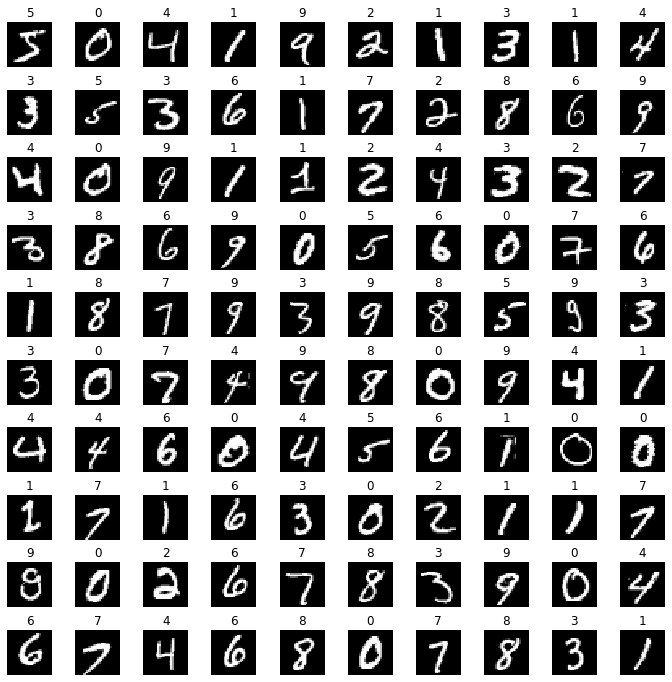

In [7]:
#Setup số hàng - số cột hiển thị dữ liệu mẫu để quan sát:
n_rows = 10
n_cols = 10

plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="gray", interpolation="nearest")
        plt.axis('off')
        plt.title(y_train[index], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
#save_fig("mnist_plot")
plt.show()

Reshape the dataset into a 2-dimensional array: 60,000 for the number of instances and 784 because 28 x 28 = 784:

In [8]:
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)

# **B.Xác định bộ tham số tối ưu (Hyperparameter Optimization)**
---
Bài toán nhận dạng chữ số viết tay là bài toán phân lớp (classification), thực hiện phân đa lớp (10 lớp ứng với các chữ số từ 0-9).

Sử dụng thuật toán RandomForest để thực hiện phân lớp; thuật toán RandomForest có một số tham số bao gồm:
* **criterion:** {"gini","entropy"} (default = "gini"): độ đo xác định thuộc tính phân tách tốt nhất trong từng bước.
* **n_estimators:** int (default = 100): thiết lập số lượng cây trong rừng
* **max_depth:** int (default = None): Thiết lập độ sâu tối đa của cây. Trường hợp setup = None cây sẽ được mở rộng cho tới khi tất cả các lá được phân tách về các lớp riêng hoặc cho tới khi tất cả các lá chứa ít hơn số mẫu được thiết lập trong tham số min_samples_split.
* **min_samples_split:** int or float (default=2): thiết lập số lượng tối thiểu của mẫu yêu cầu được tách tại một node con.
* **min_samples_leaf:** int or float (default=1): số lượng mẫu tối thiểu tại mỗi một node lá. 
* **max_features:** {"auto","sqrt","log2"}, int or float (default = "auto"): Số lượng thuộc tính được xem xét khi tìm kiếm việc phân tách tốt nhất.

Như vậy cần phải fine-tune các tham số này sao cho tìm được bộ tham số tối ưu mà ở đó độ chính xác của mô hình cao nhất.

<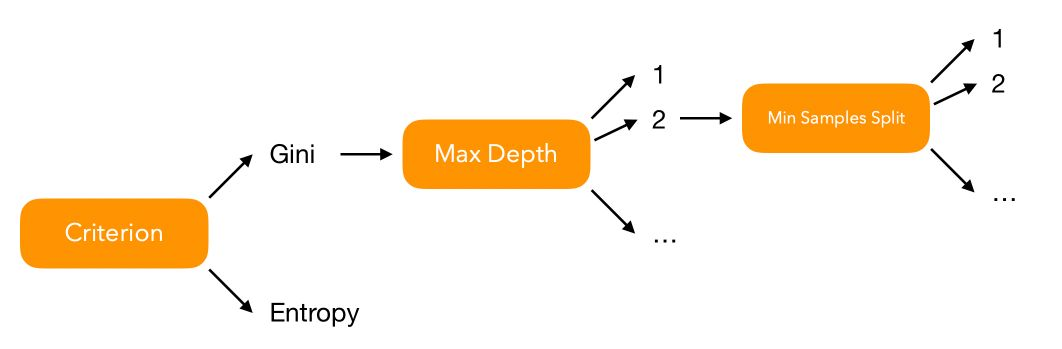>


## **B1.Grid Search**
---
Một phương pháp thủ công để có thể tìm được bộ tham số tối ưu đó là thử các giá trị của các tham số cho tới khi tìm được bộ tham số tốt nhất. Trong trường hợp này chúng ta nên sử dụng phương thức ```GridSearchCV``` của thư viện Scikit-Learn.

Chúng ta cần thiết lập các tham số và giá trị muốn thử nghiệm. GridSearch sẽ thực hiện kiểm tra tất cả các cách kết hợp các tham số này để tìm ra được tham số tối ưu cho kết quả tốt nhất.

Giả sử có 2 tham số cần fine-tune: Hyperparameter1 và Hyperparameter2, mỗi một tham số có 5 giá trị cần thử. GridSearch sẽ thực hiện kiểm tra tất cả các cách kết hợp của 2 tham số này. Như vậy hệ thống sẽ phải thử 5x5 = 25 tổ hợp tham số.

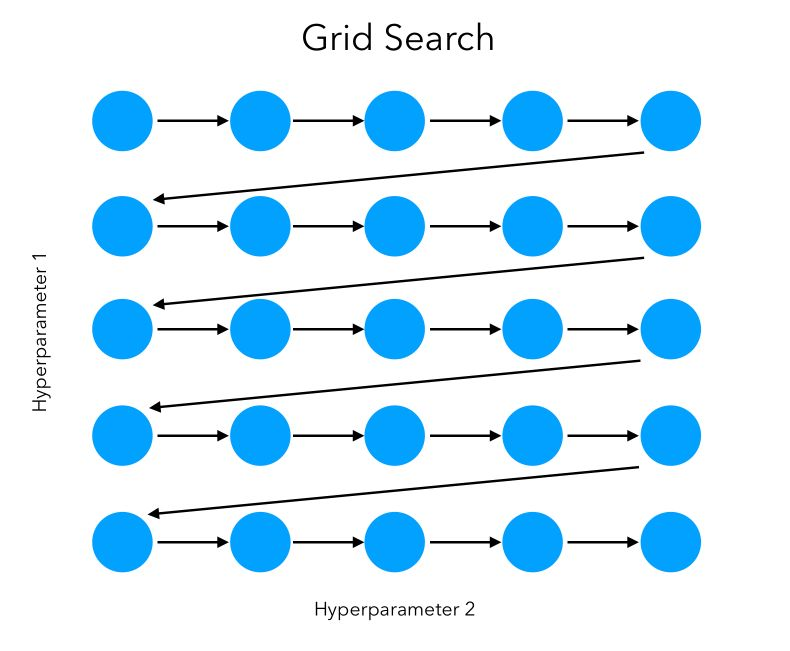




In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

#Xác định lưới tìm kiếm với 2 tham số
param_grid = [{'n_estimators': [100, 150, 350],
              'criterion':['gini','entropy']}]

#Khai báo sử dụng mô hình RandomForest cho bài toán phân lớp:
forest_clf = RandomForestClassifier()

#Sử dụng GridSearchCV của thư viện sklearn để xác định bộ tham số tốt nhất:
forest_grid_search = GridSearchCV(forest_clf, param_grid, cv=5,
                                  scoring="accuracy",
                                  return_train_score=True,
                                  verbose=True,
                                  n_jobs=-1)

#GridSearch sẽ phải thử 3x2 = 6 tổ hợp:
#Mỗi một tổ hợp sẽ thực hiện train lại model 5 lần (cv=5)
#Hệ thống sẽ phải train model để xác định best_params 6 x 5 = 30
forest_grid_search.fit(X_train, y_train)             

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'n_estimators': [100, 150, 350]}],
             return_train_score=True, scoring='accuracy', verbose=True)

Như vậy Grid Search sẽ thực hiện kiếm tra tất cả các tổ hợp của các tham số và lựa chọn bộ tham số sao cho model có độ chính xác cao nhất.
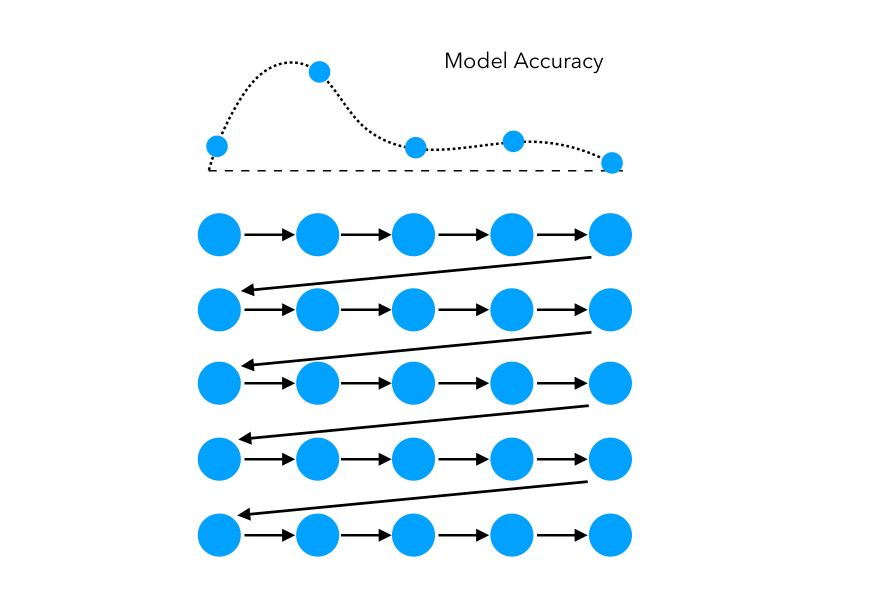

In [10]:
#Hiển thị tham số tốt nhất Grid Search tìm ra được:
forest_grid_search.best_params_

{'criterion': 'gini', 'n_estimators': 350}

In [11]:
forest_grid_search.best_estimator_

RandomForestClassifier(n_estimators=350)

In [12]:
forest_grid_search.best_score_

0.9680166666666669

**Tìm kiếm với nhiều tham số hơn:**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

#Xác định lưới tìm kiếm
param_grid2 = [{'bootstrap': [True],
     'max_depth': [6, 10],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [3, 5],
     'min_samples_split': [4, 6],
     'n_estimators': [100, 350]}]
#Khai báo sử dụng mô hình RandomForest cho bài toán phân lớp:
forest_clf = RandomForestClassifier()

#Sử dụng GridSearchCV của thư viện sklearn để xác định bộ tham số tốt nhất:
forest_grid_search2 = GridSearchCV(forest_clf, param_grid2, cv=5,
                                  scoring="accuracy",
                                  return_train_score=True,
                                  verbose=True,
                                  n_jobs=-1)

forest_grid_search2.fit(X_train, y_train)

Với thiết lập các tham số ở trên, số tổ hợp các tham số thực hiện tìm kiếm sẽ là: 1 x 2 x 2 x 2 x 2 x 2 = 32, mỗi model huấn luyện 5 lần (cv=5) như vậy hệ thống sẽ phải thực hiện 32 x 5  = 160 vòng huấn luyện model để đánh giá độ chính xác, tìm bộ tham số tốt nhất.


In [ ]:
forest_grid_search.best_params_

In [ ]:
forest_grid_search.best_estimator_

In [ ]:
forest_grid_search.best_score_

**Ưu nhược điểm của Grid Search:**
1. Ưu điểm:
* Với Grid Search sẽ tìm được bộ tham số tối ưu trong toàn bộ không gian tìm kiếm.

2. Nhược điểm:
* Thời gian thực hiện lâu, và tiêu tốn tài nguyên tính toán đặc biệt khi không gian tìm kiếm lớn. Khi giới hạn không gian tìm kiếm nhỏ khó tìm thấy được tham số tốt.

**Grid Search nên sử dụng khi nào:**
* Khi không gian tìm kiếm nhỏ tức là số lượng tổ hợp các tham số cần đánh giá là ít.
* Khi dữ liệu tập huấn luyện (Training data) nhỏ.

**Giải pháp nâng cao hiệu quả của Grid Search:**
Trước tiên thực hiện Grid search với các tham số có giá trị trong một khoảng thay đổi lớn (large-scale), để xác định được phạm vi của các tham số mà ở đó model thực hiện tốt, Sau đó thực hiện một Grid Search thứ 2 trên không gian tìm kiếm được giới hạn bởi phạm vi các tham số đã xác định được ở Grid Search ban đầu.
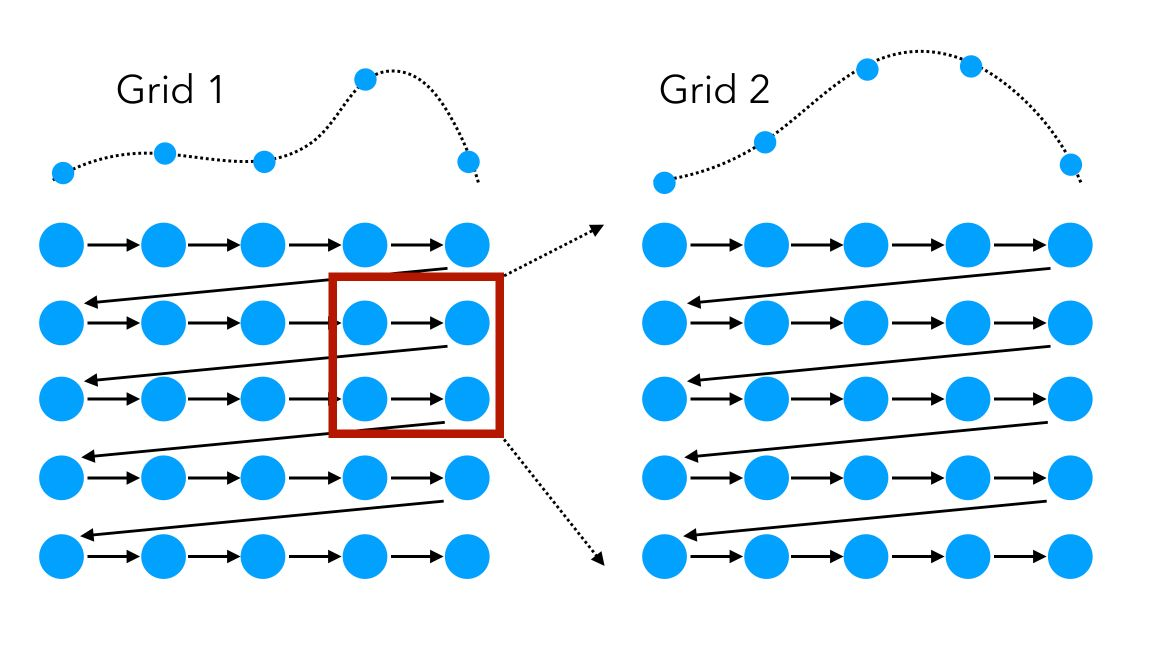

## **B2.Randomized Search**
---
Cũng tương tự như Grid Search, Randomized Search thực hiện tìm kiếm giá trị tốt nhất cho bộ tham số của mô hình. Tuy nhiên, Randomized Search không thực hiện kiểm tra lần lượt từng tổ hợp của bộ tham số mà nó sẽ kết hợp ngẫu nhiên các tham số trong phạm vi được thiết lập. Chúng ta sẽ phải thiết lập số tổ hợp ngẫu nhiên chúng ta muốn kiểm tra trong không gian các tham số.



The grid search approach is fine when you are exploring relatively few combinations, like in the previous example, but when the hyperparameter space is large, it is often preferable to use `RandomizedSearchCV` instead. This class can be used in much the same way as the `GridSearchCV` class, but instead of trying out all possible combinations, it evaluates a given number of random combinations by selecting a random value for each hyperparameter at every iteration. This approach has two main benefits:
* If you let randomized search run for, say, 1,000 iterations, this approach will explore 1,000 different values for each hyperparameter (instead of just a few values per hyperparameter with the grid search approach). 
* Simply by setting the number of iterations, you have more control over the computing budget you want to allocate to hyperparameter search.

Let's walk through the same example as before but instead use `RandomizedSearchCV`.  Since we are using `RandomizedSearchCV` we can search a larger param space than we did with `GridSearchCV`:


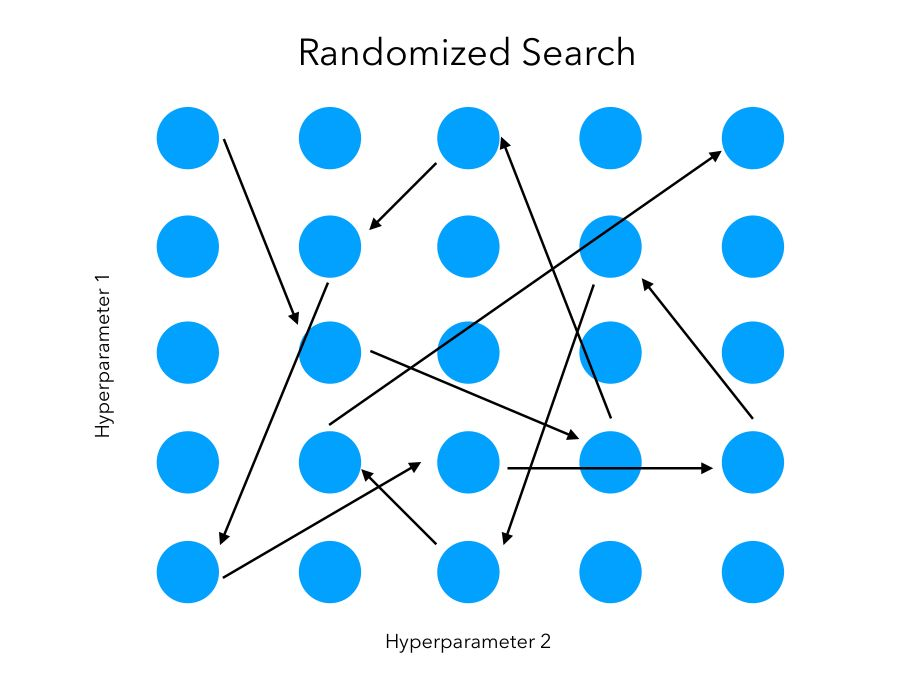

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

#Xác định không gian tìm kiếm:
param_space = {"max_depth": [6, 8, 10, 12, 14],
                "n_estimators": [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}

#Sử dụng RandomizedSearchCV chọn ngẫu nhiên 10 cách kết hợp (n_iter=10)
forest_rand_search = RandomizedSearchCV(forest_clf, param_space, n_iter=10,
                                        scoring="accuracy", verbose=True, #cv=5,
                                        n_jobs=-1, random_state=42)

#Thực hiện huấn luyện model với dữ liệu train để tìm bộ tham số tối ưu:
forest_rand_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [ ]:
forest_rand_search.best_params_

In [ ]:
forest_rand_search.best_estimator_

In [ ]:
forest_rand_search.best_score_

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_space = {"bootstrap": [True],
        "max_depth": [6, 8, 10, 12, 14],
        "max_features": ['auto', 'sqrt','log2'],
        "min_samples_leaf": [2, 3, 4],
        "min_samples_split": [2, 3, 4, 5],
        "n_estimators": [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
}

forest_rand_search = RandomizedSearchCV(forest_clf, param_space, n_iter=32,
                                        scoring="accuracy", verbose=True, cv=5,
                                        n_jobs=-1, random_state=42)

forest_rand_search.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 14.6min
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed: 81.1min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

Same as above we can see the best hyperparameters that were explored:

In [ ]:
forest_rand_search.best_params_

{'n_estimators': 300,
 'min_samples_split': 4,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 14,
 'bootstrap': True}

Also the best estimator:

In [ ]:
forest_rand_search.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=14, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

And check the best score:

In [ ]:
forest_rand_search.best_score_

0.9620666666666666

**Ưu nhược điểm của Randomized Search:**
1. Ưu điểm:
* Chúng ta có thể thiết lập phạm vi giá trị của các tham số lớn hơn (không gian tìm kiếm lớn hơn) để có tìm ra được những bộ tham số phù hợp với cùng thời gian tính toán như Grid Search, hoặc sẽ sử dụng thời gian ít hơn trong cùng không gian tìm kiếm khi chúng ta thiết lập số lượng kết hợp ngẫu nhiên nhỏ.

2. Nhược điểm:
* Thời gian thực hiện lâu, và tiêu tốn tài nguyên tính toán đặc biệt khi không gian tìm kiếm lớn. Khi giới hạn không gian tìm kiếm nhỏ khó tìm thấy được tham số tốt.

**Randomized Search nên sử dụng khi nào:**
* Khi không gian tìm kiếm nhỏ tức là số lượng tổ hợp các tham số cần đánh giá là ít.
* Khi dữ liệu tập huấn luyện (Training data) nhỏ.

**Giải pháp nâng cao hiệu quả của Random Search:**
Trước tiên thực hiện Grid search với các tham số có giá trị trong một khoảng thay đổi lớn (large-scale), để xác định được phạm vi của các tham số mà ở đó model thực hiện tốt, Sau đó thực hiện một Grid Search thứ 2 trên không gian tìm kiếm được giới hạn bởi phạm vi các tham số đã xác định được ở Grid Search ban đầu.
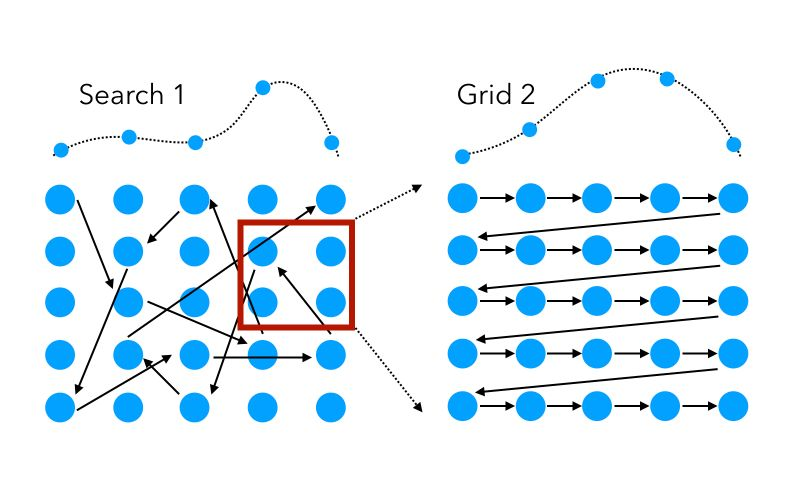

Our best performance was 0.9621 accuracy beating `GridSearchCV` by 1.5%.  As you can see since `RandomizedSearchCV` allows us to explore a larger hyperparameter space in relatively the same amount of time and generally outputs better results than `GridSearchCV`.  

You can now save this model, evaluate it on the test set, and, if you are satisfied with its performance, deploy it to production. Using randomized search is not too hard, and it works well for many fairly simple problems. When training is slow, however, (e.g., for more complex problems with larger datasets), this approach will only explore a tiny portion of the hyperparameter space. You can partially alleviate this problem by assisting the search process manually: first run a quick random search using wide ranges of hyperparameter values, then run another search using smaller ranges of values centered on the best ones found during the first run, and so on. This approach will hopefully zoom in on a good set of hyperparameters. However, it's very time consuming, and probably not the best use of your time.

## **B3.Bayesian Optimization**
---

Fortunately, there are many techniques to explore a search space much more efficiently than randomly. Their core idea is simple: when a region of the space turns out to be good, it should be explored more. Such techniques take care of the "zooming" process for you and lead to much better solutions in much less time. 

One such technique is called Bayesian Optimization and we will use Scikit-Optimize (Skopt) [https://scikit-optimize.github.io/](https://scikit-optimize.github.io) to perform Bayesian Optimization.  Skopt is a general-purpose optimization library that performs Bayesian Optimization with its class `BayesSearchCV` using an interface similar to `GridSearchCV`.  

If you don't have Skopt already installed go ahead and run the following line of code in your virtual environment:

In [ ]:
!pip install scikit-optimize

     |████████████████████████████████| 81kB 2.4MB/s eta 0:00:011


There are only 2 main differences when performing Bayesian Optimization using Skopt's `BayesSearchCV`.  First, when creating your search space you need to make each hyperparameters space a probability distribution as opposed to using lists for `GridSearchCV`. Skopt makes this easy for you by importing Real, Categorical, and Integer from skopt.space.

* **Real**: Continuous hyperparameter space.
* **Integer**: Discrete hyperparameter space.
* **Categorical**: Categorical hyperparameter space.

Below you can see examples of using both the categorical and integer functions. For categorical spaces simply imput a list inside the function. For Integer spaces input the minimum and maximum values you want `BayesSearchCV` to explore.

In [ ]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

search_space = {"bootstrap": Categorical([True, False]), # values for boostrap can be either True or False
        "max_depth": Integer(6, 20), # values of max_depth are integers from 6 to 20
        "max_features": Categorical(['auto', 'sqrt','log2']), 
        "min_samples_leaf": Integer(2, 10),
        "min_samples_split": Integer(2, 10),
        "n_estimators": Integer(100, 500)
    }

def on_step(optim_result):
    """
    Callback meant to view scores after
    each iteration while performing Bayesian
    Optimization in Skopt"""
    score = forest_bayes_search.best_score_
    print("best score: %s" % score)
    if score >= 0.98:
        print('Interrupting!')
        return True

forest_bayes_search = BayesSearchCV(forest_clf, search_space, n_iter=32, # specify how many iterations
                                    scoring="accuracy", n_jobs=-1, cv=5)

forest_bayes_search.fit(X_train, y_train, callback=on_step) # callback=on_step will print score after each iteration

best score: 0.9336833333333333
best score: 0.9495833333333333
best score: 0.9495833333333333
best score: 0.96815
best score: 0.96815
best score: 0.96815
best score: 0.96815
best score: 0.96815
best score: 0.96815
best score: 0.96815
best score: 0.96815
best score: 0.9697333333333333
best score: 0.9697333333333333
best score: 0.9697333333333333
best score: 0.9697333333333333
best score: 0.9697333333333333
best score: 0.9697333333333333
best score: 0.9697333333333333
best score: 0.9697333333333333
best score: 0.9697333333333333
best score: 0.9697333333333333
best score: 0.9697333333333333
best score: 0.9697333333333333
best score: 0.9697333333333333
best score: 0.9697333333333333
best score: 0.9697333333333333
best score: 0.9697333333333333


//anaconda3/envs/metis/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


best score: 0.97
best score: 0.97
best score: 0.97
best score: 0.97
best score: 0.97


BayesSearchCV(cv=5, error_score='raise',
              estimator=RandomForestClassifier(bootstrap=True,
                                               class_weight=None,
                                               criterion='gini', max_depth=None,
                                               max_features='auto',
                                               max_leaf_nodes=None,
                                               min_impurity_decrease=0.0,
                                               min_impurity_split=None,
                                               min_samples_leaf=1,
                                               min_samples_split=2,
                                               min_weight_fraction_leaf=0.0,
                                               n_estimators='warn', n_jobs=None,
                                               oob_score=False,
                                               random_...
                             'max_depth': Integer(lo

Just like in Scikit-Learn we can view the best parameters:

In [ ]:
forest_bayes_search.best_params_

OrderedDict([('bootstrap', False),
             ('max_depth', 20),
             ('max_features', 'sqrt'),
             ('min_samples_leaf', 2),
             ('min_samples_split', 2),
             ('n_estimators', 500)])

And the best estimator:

In [ ]:
forest_bayes_search.best_estimator_

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=20, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

And the best score:

In [ ]:
forest_bayes_search.best_score_

0.97

Bayesian Optimization allowed us to improve our accuracy by another whole percent in the same amount of iterations as Randomized Search.  I hope this convinces you to stray away from your comfort zone using `GridSearchCV` and `RandomizedSearchCV` to try implementing something new like `BayesSearchCV` in your next project.  Hyperparameter searching can be tedious, but there are tools that can do the tedious work for you.

## **B4.Fine-Tuning Neural Network Hyperparameters**
---

The flexibility of neural networks is also one of their main drawbacks: there are many hyperparameters to tweak. Not only can you use any imaginable network architecture, but even in a simple MLP you can change the number of layers, the number of neurons per layer, the type of activation function to use in each layer, the weight initialization logic, and much more. It can be hard to know what combination of hyperparameters is the best for your task.

One option is to simply try many combinations of hyperparameters and see which one works best on the validation set (or use K-fold cross-validation). For example, we can use `GridSearchCV` or `RandomizedSearchCV` to explore the hyperparameter space.  To do this, we need to wrap our Keras models in objects that mimic regular Scikit-Learn classifiers. The first step is to create a function that will build and compile a Keras model, given a set of hyperparameters:

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()

Since we are going to train the neural network using gradient descent, we must scale the input features. For simplicity, we'll scale the pixel intensities down to the 0-1 range by dividing them by 255.0 (this also converts them to floats):

In [ ]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

In [ ]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[28, 28]):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(10, activation="softmax"))
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model

This function creates a simple Sequential model for multiclass classification with the given input shape and the given number of hidden layers and neurons, and it compiles it using an SGD optimizer configured with the specified learning rate.  

Next, let's create a KerasClassifier based on this `build_model()` function:

In [ ]:
keras_clf = keras.wrappers.scikit_learn.KerasClassifier(build_model)

The `KerasClassifier` object is a thin wrapper around the Keras model built using `build_model()`. This will allow us to use this object like a regular Scikit-Learn classifier: we can train it using its `fit()` method, then evaluate it using its `score()` method, and use it to make predictions using its `predict()` method.

We don't want to train and evaluate a single model like this though, we want to train hundreds of variants and see which one performs best on the validation set. Since there are many hyperparamters, it is preferable to use randomized search rather than grid search. Let's try to explore the number of hidden layers, the number of neurons, and the learning rate:

In [ ]:
from scipy.stats import reciprocal

keras_param_space = {"n_hidden": [1, 2, 3, 4],
                      "n_neurons": np.arange(30, 300),
                      "learning_rate": reciprocal(3e-4, 3e-2) 
}

keras_rand_search = RandomizedSearchCV(keras_clf, keras_param_space, n_iter=20, 
                                   cv=5, scoring="accuracy", n_jobs=-1, verbose=True)

keras_rand_search.fit(X_train, y_train, epochs=100,
                       validation_data=(X_valid, y_valid),
                       callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 43.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 135.5min finished


Epoch 1/100
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5520 - accuracy: 0.8586 - val_loss: 0.3218 - val_accuracy: 0.9122
Epoch 2/100
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2984 - accuracy: 0.9168 - val_loss: 0.2512 - val_accuracy: 0.9318
Epoch 3/100
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2488 - accuracy: 0.9312 - val_loss: 0.2181 - val_accuracy: 0.9422
Epoch 4/100
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2168 - accuracy: 0.9406 - val_loss: 0.1955 - val_accuracy: 0.9484
Epoch 5/100
1719/1719 [==============================] - 2s 1ms/step - loss: 0.1930 - accuracy: 0.9463 - val_loss: 0.1753 - val_accuracy: 0.9548
Epoch 6/100
1719/1719 [==============================] - 2s 1ms/step - loss: 0.1744 - accuracy: 0.9521 - val_loss: 0.1608 - val_accuracy: 0.9590
Epoch 7/100
1719/1719 [==============================] - 2s 1ms/step - loss: 0.1591 - accuracy: 0.9558 - val_loss: 0.1497 - val_ac

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x1a0fb0908>,
                   iid='warn', n_iter=20, n_jobs=-1,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a0d0b9b0>,
                                        'n_hidden': [1, 2, 3, 4],
                                        'n_neurons': array([ 30,  31,  32,  33,  34,  35,  36,  37,  38,  3...
       238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250,
       251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263,
       264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276,
       277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289,
       290, 291, 292, 293, 294, 295, 296, 297, 298, 299])},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, sc

In [ ]:
keras_rand_search.best_params_

{'learning_rate': 0.015529337745078654, 'n_hidden': 1, 'n_neurons': 237}

In [ ]:
keras_rand_search.best_estimator_

In [ ]:
keras_rand_search.best_score_

0.9752909090909091

Our accuracy increased by another .5%! The last step is to see how each model performed on the test set (see below).

# **C.Kết luận**
---

Hyperparameter tuning is still an active area of research, and different algorithms are being produced today. But having basic algorithms in your back pocket can alleviate a lot of the tedious work searching for the best hyperparameters.

Remember, randomized search is almost always preferable then grid search unless you have very few hyperparameters to explore. If you have a more complex problem using a larger dataset you might want to turn to a technique that explores a search space much more efficiently like Bayesian Optimization.

In [ ]:
forest_grid_search.score(X_test, y_test)

0.9486

In [ ]:
forest_rand_search.score(X_test, y_test)

0.9662

In [ ]:
forest_bayes_search.score(X_test, y_test)

0.9721

In [ ]:
keras_rand_search.score(X_test, y_test)

0.9773